In [1]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt


In [2]:
# Make it possible to import `pallets` from parent dir

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), '..'))
)
from pallets import images, datasets, models


# Prepare Datasets

Create DataLoaders for both:

* the RGBA dataset
* the one-hot encoded dataset

In [3]:
# Unique colors for one punk

image = images.get_punk_tensor(0)
print(f"image shape: {image.shape}\n")

colors = images.one_image_colors(image)
print(f"total colors: {len(colors)}\n")
print(f"image colors:\n{colors}")


image shape: torch.Size([4, 24, 24])

total colors: 7

image colors:
[[  0   0   0   0]
 [  0   0   0 255]
 [ 80 124  51 255]
 [ 93 139  67 255]
 [ 95  29   9 255]
 [174 139  97 255]
 [255 246 142 255]]


In [4]:
# Unique colors for all punks

all_colors = images.get_punk_colors()
print(f"colors found: {len(all_colors)}")


colors found: 222


### RGBA Dataset

### One Hot Dataset

1. Generate a one hot representation for all 222 colors.

2. Instantiate a mapper to go from each color to its one hot representation and back.

3. Create dataloader for punks that represents its color data as one hot vectors.

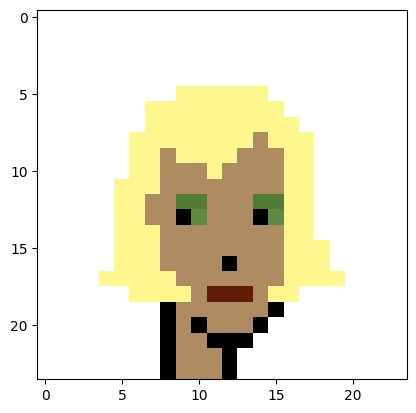

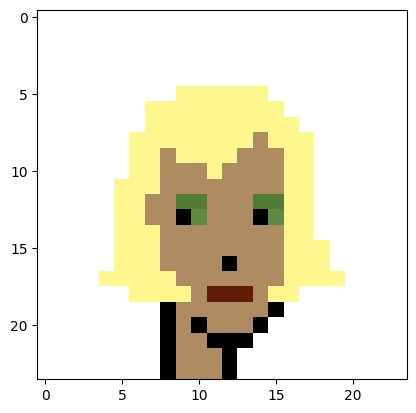

In [5]:
# Mapper from color to one hot

from torchvision.transforms.functional import to_pil_image

mapper = datasets.ColorOneHotMapper(all_colors)

one_hot_encoded_image = datasets.rgb_to_one_hot(image, mapper)
restored = datasets.one_hot_to_rgb(one_hot_encoded_image, mapper)

plt.imshow(to_pil_image(image))
plt.show()

plt.imshow(to_pil_image(restored))
plt.show()


In [6]:
# Start with a color
test_color = all_colors[2]
print(f"color:\n{test_color}\n")

# Convert color to one hot
test_one_hot = mapper.to_one_hot(test_color)
print(f"one-hot encoding:\n{test_one_hot}\n")

# Convert one hat back to original color
retrieved_color = mapper.to_color(test_one_hot)
print(f"retrieved color:\n{retrieved_color}")


color:
[  0  64 255 255]

one-hot encoding:
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

retrieved color:
[  0  64 255 255]


In [7]:
# Punks Dataset

dataset = datasets.OneHotEncodedImageDataset(mapper, test_size=2000)
print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")

train_sampler = SubsetRandomSampler(dataset.train_idx)
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")

test_sampler = SubsetRandomSampler(dataset.test_idx)
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")



dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  556

test sampler:   2000
  - sample id:  7473



# Prepare DataLoaders

In [8]:
# Punks DataLoader

batch_size = 32
shuffle = True
num_workers = 4

train_loader = DataLoader(
    dataset, batch_size=batch_size, num_workers=0, sampler=train_sampler
)

test_loader = DataLoader(
    dataset, batch_size=batch_size, num_workers=0, sampler=test_sampler
)

print(f"batch size:   {batch_size}")

train_punk = next(iter(train_loader))
print(f"  - train punk: {train_punk.shape}")

test_punk = next(iter(train_loader))
print(f"  - test punk:  {test_punk.shape}")


batch size:   32
  - train punk: torch.Size([32, 222, 24, 24])
  - test punk:  torch.Size([32, 222, 24, 24])


# Train Model

In [9]:
# Model: One Hot
autoencoder = models.OneHotAutoencoder()
criterion = torch.nn.MSELoss()

# Model: Simple Conv
# autoencoder = models.SimpleConvAutoencoder()
# criterion = torch.nn.MSELoss()

# Cue training montage
train_losses, test_losses = models.train(
    autoencoder, criterion, train_loader, test_loader,
    learn_rate=1e-3, epochs=5
)


epoch [1/5]
  - train loss: 0.011101825165562332
  - test loss:  0.0014313087661913227
epoch [2/5]
  - train loss: 0.0013993972749449313
  - test loss:  0.00134047698636081
epoch [3/5]
  - train loss: 0.0012301854859106242
  - test loss:  0.0011237465216600824
epoch [4/5]
  - train loss: 0.001066529650473967
  - test loss:  0.001004138944803604
epoch [5/5]
  - train loss: 0.0009781468058936299
  - test loss:  0.0009222191431382228


# Model Output to Image

In [10]:
# Reconstruct random data for test

if isinstance(autoencoder, models.SimpleConvAutoencoder):
    example_input = torch.rand(32, 222, 24, 24)
else:
    example_input = torch.rand(32, 222*24*24)

reconstructed = autoencoder(example_input)
print(reconstructed.shape)


torch.Size([32, 222, 24, 24])


In [11]:
# Get image from batch

image_batch = reconstructed.detach().cpu().numpy()
some_image = image_batch[0]

if isinstance(autoencoder, models.SimpleConvAutoencoder):
    # if model is Conv2D, dimensions were changed during training
    # and need to be adjustmented back
    some_image = np.transpose(some_image, (1, 2, 0))



In [12]:
# 24x24 image with RGBA colors
some_image = datasets.one_hot_to_rgb(some_image, mapper)
# some_image.shape
some_image


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

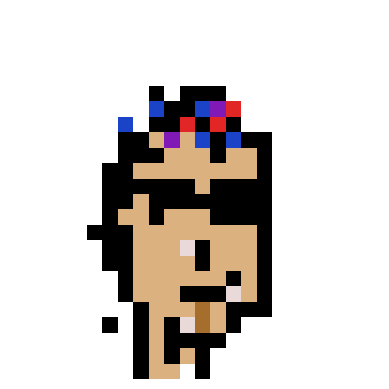

In [13]:
from torchvision.transforms.functional import to_pil_image

# print(type(some_image))
# pil_image = to_pil_image(torch.tensor(some_image))
pil_image = to_pil_image(some_image.clone().detach())
plt.imshow(pil_image)
plt.axis('off')
plt.show()



# Tests

In [14]:
test_losses


[0.0014313087661913227,
 0.00134047698636081,
 0.0011237465216600824,
 0.001004138944803604,
 0.0009222191431382228]

In [15]:
train_losses


[0.011101825165562332,
 0.0013993972749449313,
 0.0012301854859106242,
 0.001066529650473967,
 0.0009781468058936299]

<function matplotlib.pyplot.show(close=None, block=None)>

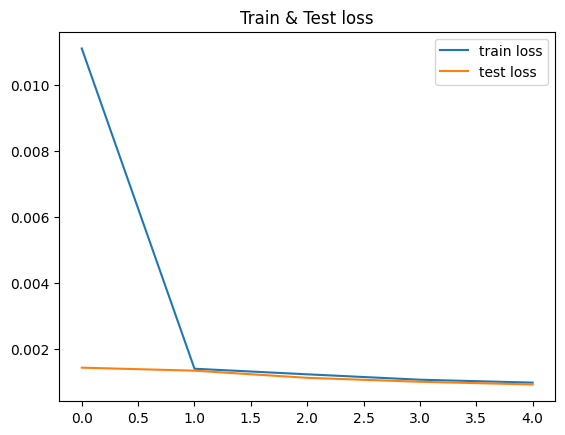

In [16]:
# plt.figure(figsize=(10,5))
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show
